In [31]:
import math
import numpy as np 
import matplotlib.pyplot as plt 

In [32]:
N = 50
D = 1
dx = 1/N
w = 1.8
e = 10**(-5)

In [33]:
def init(N):
    grid = np.zeros((N,N))
    grid[0] = np.ones(N)
    return grid

In [49]:
def analytic(Y, t, t_max, D):
    c = 0
    for i in range(t_max):
        Z_neg = (1 - Y + 2*i) / (2* np.sqrt(D*t))
        Z_pos = (1 + Y + 2*i) / (2* np.sqrt(D*t))
        c = c + math.erfc(Z_neg) - math.erfc(Z_pos)
    return c

1.4 Jacobi iteration

In [35]:
def update_J(Y):
    Y_prev = np.copy(Y)
    for j in range(1, len(Y)-1):
        for i in range(len(Y)):
            if i == 0:
                 Y[j,i] = (1/4) * (Y_prev[j+1,i] + Y_prev[j-1,i]+ Y_prev[j,i+1] +Y_prev[j,-1]) 
            elif i == N-1:
                 Y[j,i] = (1/4) * (Y_prev[j+1,i] + Y_prev[j-1,i]+ Y_prev[j,0] +Y_prev[j,i-1]) 
            else:
                 Y[j,i] = (1/4) * (Y_prev[j+1,i] + Y_prev[j-1,i]+ Y_prev[j,i+1] +Y_prev[j,i-1])
    return(Y)  

1.5 The Gauss_Seidel iteration

In [36]:
def update_GS(Y):
    for j in range(1, len(Y)-1):
        for i in range(len(Y)):
            if i == 0:
                 Y[j,i] =  (1/4) * (Y[j+1,i] + Y[j-1,i] + Y[j,i+1] + Y[j,-1]) 
            elif i == N-1:
                 Y[j,i] =  (1/4) * (Y[j+1,i] + Y[j-1,i] + Y[j,0] + Y[j,i-1]) 
            else:
                 Y[j,i] =  (1/4) * (Y[j+1,i] + Y[j-1,i] + Y[j,i+1] + Y[j,i-1])
    return(Y)  

1.6 Successice Over Relaxation

In [77]:
def update_SOR(Y, w, N = 50, objects = []):
    for j in range(1, len(Y)-1):
        for i in range(len(Y)):
            if i == 0:
                 Y[j,i] = (1-w)*Y[j,i] + (w/4) * (Y[j+1,i] + Y[j-1,i] + Y[j,i+1] + Y[j,-1]) 
            elif i == N-1:
                 Y[j,i] = (1-w)*Y[j,i] + (w/4) * (Y[j+1,i] + Y[j-1,i] + Y[j,0] + Y[j,i-1]) 
            else:
                 Y[j,i] = (1-w)*Y[j,i] + (w/4) * (Y[j+1,i] + Y[j-1,i] + Y[j,i+1] + Y[j,i-1])
        if len(objects) > 0:
            Y[objects[0,0]:objects[0,1], objects[1,0]:objects[1,1]] = 0
            if len(objects) == 4:
                Y[objects[2,0]:objects[2,1], objects[3,0]:objects[3,1]] = 0    
    return(Y)  

In [79]:
def iterative(model_type, e, w, N=50):
    Y = init(N)
    delta = []
    print(np.shape(Y))
    k = 1
    if model_type == 0:      # Jacobian iteration
        Y_prev = np.copy(Y)
        Y = update_J(Y)
        diff = np.abs(Y - Y_prev)
        diff_val = np.amax(diff)
        delta.append(diff_val)
        while(diff_val > e):
            k = k+1
            Y_prev = np.copy(Y)
            Y = update_J(Y)
            diff = np.abs(Y - Y_prev)
            diff_val = np.amax(diff)
            delta.append(diff_val)
    if model_type == 1:       # Gauss_Seidel iteration
        Y_prev = np.copy(Y)
        Y = update_GS(Y)
        diff = np.abs(Y - Y_prev)
        diff_val = np.amax(diff)
        delta.append(diff_val)
        while(diff_val > e):
            k = k+1
            Y_prev = np.copy(Y)
            Y = update_GS(Y)
            diff = np.abs(Y - Y_prev)
            diff_val = np.amax(diff)
            delta.append(diff_val)
    if model_type == 2:      # Successice Over Relaxation iteration
        Y_prev = np.copy(Y)
        print(N)
        Y = update_SOR(Y, w, N)
        diff = np.abs(Y - Y_prev)
        diff_val = (np.amax(diff))
        delta.append(diff_val)
        while(diff_val > e):
            k = k+1
            Y_prev = np.copy(Y)
            Y = update_SOR(Y, w, N)
            diff = np.abs(Y - Y_prev)
            diff_val = (np.amax(diff))
            delta.append(diff_val)
    return(Y, k, delta)

In [ ]:
grid_0, total_iterations_0, delta_0 = iterative(0, e, w)
grid_1, total_iterations_1, delta_1 = iterative(1, e, w)
grid_2, total_iterations_2, delta_2 = iterative(2, e, w)

Jacobian iteration till convergence:  4068


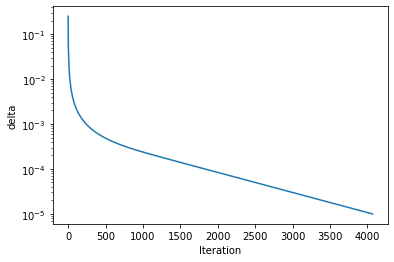

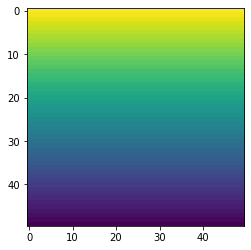

Gaus-Seidel iteration till convergence:  2361


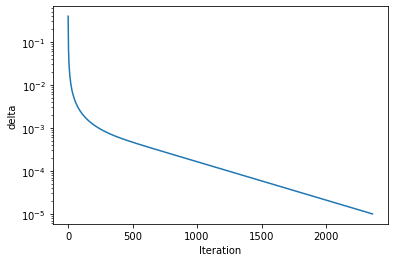

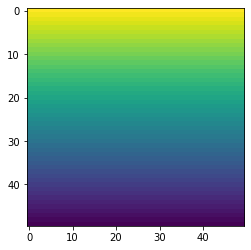

SOR iteration till convergence:  366


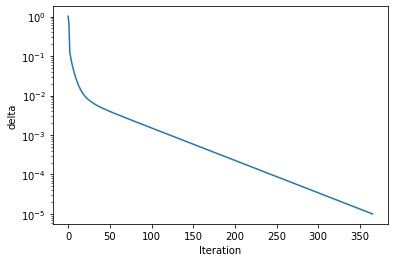

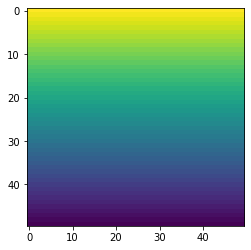

In [106]:
print("Jacobian iteration till convergence: " , total_iterations_0)
plt.plot(delta_0)
plt.xlabel("Iteration")
plt.ylabel("delta")
plt.yscale("log")
plt.show()
plt.imshow(grid_0)
plt.show()
print("Gaus-Seidel iteration till convergence: " , total_iterations_1)
plt.plot(delta_1)
plt.xlabel("Iteration")
plt.ylabel("delta")
plt.yscale("log")
plt.show()
plt.imshow(grid_1)
plt.show()
print("SOR iteration till convergence: " , total_iterations_2)
plt.plot(delta_2)
plt.xlabel("Iteration")
plt.ylabel("delta")
plt.yscale("log")
plt.show()
plt.imshow(grid_2)
plt.show()

In [55]:
C_list = []
for y in np.arange(0, 1, 0.01):
    C = analytic(y, 1, 50, D)
    C_list.append(C)
C_list.reverse() # 

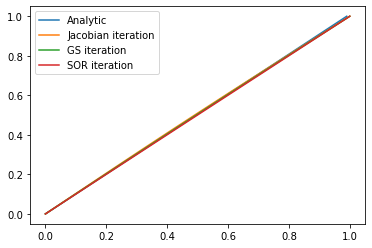

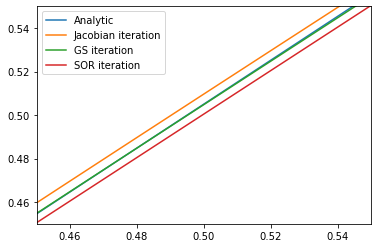

In [58]:
plt.plot(C_list, np.linspace(1, 0, 100), label = "Analytic")
plt.plot(grid_0[:,0], np.linspace(1,0,N), label = "Jacobian iteration")
plt.plot(grid_1[:,0], np.linspace(1,0,N), label = "GS iteration")
plt.plot(grid_2[:,0], np.linspace(1,0,N), label = "SOR iteration")
plt.legend()
plt.show()

plt.plot(C_list, np.linspace(1, 0, 100), label = "Analytic")
plt.plot(grid_0[:,0], np.linspace(1,0,N), label = "Jacobian iteration")
plt.plot(grid_1[:,0], np.linspace(1,0,N), label = "GS iteration")
plt.plot(grid_2[:,0], np.linspace(1,0,N), label = "SOR iteration")
plt.ylim(0.45, 0.55)
plt.xlim(0.45, 0.55)
plt.legend()
plt.show()

In [89]:
w_list = np.arange(1.7,2,0.05)
N_list = np.arange(50, 150, 5)
iter_list = np.zeros((len(w_list), len(N_list)))
delta_list = []
for i in range(len(w_list)):
    for j in range(len(N_list)):
        grid, k, delta = iterative(2, e, w_list[i], N_list[j])
        iter_list[i, j] = k
        delta_list.append(delta)
        
print(iter_list)
print(delta)

(50, 50)
50
(55, 55)
55
(60, 60)
60
(65, 65)
65
(70, 70)
70
(75, 75)
75
(80, 80)
80
(85, 85)
85
(90, 90)
90
(95, 95)
95
(100, 100)
100
(105, 105)
105
(110, 110)
110
(115, 115)
115
(120, 120)
120
(125, 125)
125
(130, 130)
130
(135, 135)
135
(140, 140)
140
(145, 145)
145
(50, 50)
50
(55, 55)
55
(60, 60)
60
(65, 65)
65
(70, 70)
70
(75, 75)
75
(80, 80)
80
(85, 85)
85
(90, 90)
90
(95, 95)
95
(100, 100)
100
(105, 105)
105
(110, 110)
110
(115, 115)
115
(120, 120)
120
(125, 125)
125
(130, 130)
130
(135, 135)
135
(140, 140)
140
(145, 145)
145
(50, 50)
50
(55, 55)
55
(60, 60)
60
(65, 65)
65
(70, 70)
70
(75, 75)
75
(80, 80)
80
(85, 85)
85
(90, 90)
90
(95, 95)
95
(100, 100)
100
(105, 105)
105
(110, 110)
110
(115, 115)
115
(120, 120)
120
(125, 125)
125
(130, 130)
130
(135, 135)
135
(140, 140)
140
(145, 145)
145
(50, 50)
50
(55, 55)
55
(60, 60)
60
(65, 65)
65
(70, 70)
70
(75, 75)
75
(80, 80)
80
(85, 85)
85
(90, 90)
90
(95, 95)
95
(100, 100)
100
(105, 105)
105
(110, 110)
110
(115, 115)
115
(120, 120)

KeyboardInterrupt: 

In [93]:
print(iter_list)
print(delta_list[0])

[[ 554.  654.  761.  873.  991. 1114. 1242. 1374. 1512. 1653. 1799. 1948.
  2101. 2258. 2419. 2582. 2749. 2919. 3091. 3266.]
 [ 460.  544.  633.  728.  827.  931. 1039. 1151. 1267. 1387. 1511. 1638.
  1768. 1902. 2038. 2178. 2320. 2466. 2613. 2764.]
 [ 366.  435.  507.  584.  665.  749.  837.  929. 1024. 1122. 1224. 1328.
  1435. 1545. 1658. 1773. 1891. 2011. 2133. 2258.]
 [ 273.  325.  381.  440.  502.  567.  635.  706.  780.  856.  935. 1016.
  1099. 1185. 1273. 1363. 1455. 1549. 1646. 1744.]
 [ 175.  211.  250.  291.  335.  380.  428.  477.  529.  582.  638.  695.
   753.  814.  876.  940. 1005. 1072. 1141. 1210.]
 [ 212.  217.  219.  225.  228.  232.  241.  234.  256.  284.  314.  346.
   378.  412.  447.  482.  519.  556.  594.  633.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.]]
[0.9197554347826087, 0.527348174621928, 0.11518742795962239, 0.08150688149455049, 0.060447328893331376, 0.047434265290678734

K)

In [103]:
def SOR_objects(Y, w, ob):
    Y_prev = np.copy(Y)
    Y = update_SOR(Y, w, objects = ob)
    diff = np.abs(Y - Y_prev)
    diff_val = (np.amax(diff))
    k = 1
    while(diff_val > e):
        k=k+1
        Y_prev = np.copy(Y)
        Y = update_SOR(Y, w, objects = ob)
        diff = np.abs(Y - Y_prev)
        diff_val = (np.amax(diff))
    return(Y, k)

In [104]:
Y = init(N)
# ob = [(20,30), (20,30)]
# ob = [(10, 20), (10, 40)]
ob = np.array([[10, 20], [10, 20], [10, 20], [30, 40]])
print(ob[0,0])
grid_obj, iterations = SOR_objects(Y,w, ob)


10


112


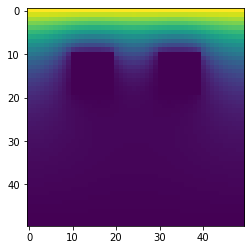

In [105]:
print (iterations)
plt.imshow(grid_obj)
plt.show()